<a href="https://colab.research.google.com/github/shreyasri258/Team-Chat/blob/main/ChatGPT_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data/glove

!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

mkdir: cannot create directory ‘data/glove’: No such file or directory
--2023-10-01 08:26:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-10-01 08:26:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-10-01 08:26:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import string
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras import models
from keras import layers
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

%matplotlib inline

In [ ]:

def remove_links(tweet):
    '''Ex:- https://www.google.com.eg/'''
    return re.sub("(http[s]?:\S+)","", tweet)

def remove_shortwords(tweet):
    tweet=re.sub("'", "", tweet)
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if  len(word) > 1]
    return " ".join(clean_tweet)


def remove_mentions(tweet):
    '''@User Mention'''
    return re.sub("@[A-Za-z0-9_]+","", tweet)


def remove_stopwords(tweet):
    stopwords_list = stopwords.words('english')
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if (word not in stopwords_list)]
    return " ".join(clean_tweet)

def remove_nonwords(tweet):
    tweet = re.sub('[^\w]',' ',tweet)
    return tweet

def clean_text(tweet):
    tweet = remove_links(tweet)
    tweet = remove_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_stopwords(tweet)
    tweet = remove_nonwords(tweet)
    tweet = remove_shortwords(tweet)
    tweet = tweet.strip()
    return tweet

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
num_of_words = 32000
max_num_of_words = 50 # in sequence
num_of_dimensions = 300  # For GloVe word embeddings

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/file.csv')
df.tweets = df.tweets.apply(clean_text)

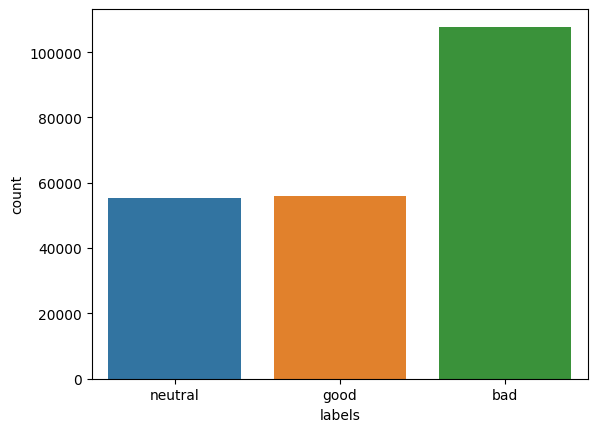

In [ ]:
tweets_majority=sns.countplot(data=df, x='labels')
plt.show()
tweets_majority_fig = tweets_majority.get_figure()


In [ ]:
tweets_majority_fig.savefig("/content/drive/MyDrive/Colab Notebooks/Majority of tweets.png")


In [ ]:
tokenized_tweet = df['tweets'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()


0    [chatgpt, optimizing, language, models, dialogue]
1    [try, talking, chatgpt, new, ai, system, optim...
2    [chatgpt, optimizing, language, models, dialog...
3    [thrilled, share, chatgpt, new, model, optimiz...
4    [minutes, ago, released, new, chatgpt, nand, u...
Name: tweets, dtype: object

In [ ]:
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

df['tweets'] = tokenized_tweet
df.head()

,Unnamed: 0,tweets,labels
0,0,chatgpt optimizing language model dialogue,neutral
1,1,try talking chatgpt new ai system optimized di...,good
2,2,chatgpt optimizing language model dialogue ai ...,neutral
3,3,thrilled share chatgpt new model optimized dia...,good
4,4,minute ago released new chatgpt nand use right,bad


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.tweets, df.labels, test_size=0.2, random_state=42)
print(f'# number of training data: {X_train.shape[0]}')
print(f'# number of testing data: {X_test.shape[0]}')

# number of training data: 175435
# number of testing data: 43859


In [ ]:
training_data=pd.DataFrame({'tweets':X_train[:], 'labels':y_train[:]})
testing_data=pd.DataFrame({'tweets':X_test[:], 'labels':y_test[:]})
training_data.to_csv('/content/drive/MyDrive/Colab Notebooks/training_data.csv')
testing_data.to_csv('/content/drive/MyDrive/Colab Notebooks/testing_data.csv')


In [ ]:
tokenizer = Tokenizer(num_words=num_of_words,filters=string.punctuation)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
data_description = X_train.apply(lambda x: len(x.split(' ')))
data_description_df=pd.DataFrame(data_description.describe())
data_description_df


,tweets
count,175435.000000
mean,12.629202
std,7.920655
min,1.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,49.000000


In [ ]:
max_num_of_words=49


X_train = pad_sequences(X_train_sequences, maxlen=max_num_of_words)
X_test = pad_sequences(X_test_sequences, maxlen=max_num_of_words)

print(f'Shape of samples: {X_train.shape}')

Shape of samples: (175435, 49)


In [ ]:
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))
y_test[0]


array([1., 0., 0.], dtype=float32)

In [ ]:
embedding_dict = {}
glove = open(f'/content/glove.6B.300d.txt', encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = vector
glove.close()

In [ ]:
embedding_matrix = np.zeros((num_of_words, 300))

for w, i in tokenizer.word_index.items():
    if i < num_of_words:
        vect = embedding_dict.get(w)
        if vect is not None:
            embedding_matrix[i] = vect
    else:
        break

print ('Embedding Matrix Shape: ',embedding_matrix.shape)

Embedding Matrix Shape:  (32000, 300)


In [ ]:
def plotting_model_measurements(history,model_name,trial_num):
    title_name=f'{model_name} Model (Trial-{trial_num})'
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    fig.suptitle(title_name, fontsize=16)
    fig.trial_num=trial_num

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/{model_name} Model Accuracy and Loss (Trial No.:{trial_num}).png')
    plt.draw()
    plt.tight_layout()

In [ ]:
def build_CNN(Conv1D_1,Conv1D_2,Conv1D_3,_learning_rate,embedding_trainable,model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer'))
    if Conv1D_1:
      model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
      model.add(MaxPooling1D(3))

    if Conv1D_2:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    if Conv1D_3:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(3, activation='softmax',name='Output_Layer'))
    model.layers[0].set_weights([embedding_matrix])
    if embedding_trainable:
       model.layers[0].trainable = True
    else:
       model.layers[0].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate), metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    return model


cnn_model_trials_dict = {
             'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}

In [ ]:
# Trial-1 (embedding_trainable=True)

cnn_model_trial1 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.0001, model_name='CNN_Trial-1')
cnn_model_trial1_history = cnn_model_trial1.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-1'''
tf.keras.utils.plot_model(cnn_model_trial1, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CNN Model (Trial 1).png')

cnn_model_trials_dict['Embedding layer Trainable'][0]='Yes'



# Trial-2 (embedding_trainable=False)

cnn_model_trial2 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.01, model_name='CNN_Trial-2')
cnn_model_trial2_history = cnn_model_trial2.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(cnn_model_trial2, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CNN Model (Trial 2).png')

cnn_model_trials_dict['Embedding layer Trainable'][1]='No'


# Trial-3 (embedding_trainable=False)

cnn_model_trial3 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-3')
cnn_model_trial3_history = cnn_model_trial3.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(cnn_model_trial3, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CNN Model (Trial 3).png')

cnn_model_trials_dict['Embedding layer Trainable'][2]='No'




# Trial-4 (embedding_trainable=True)

cnn_model_trial4 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-4')
cnn_model_trial4_history = cnn_model_trial4.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(cnn_model_trial4, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CNN Model (Trial 4).png')

cnn_model_trials_dict['Embedding layer Trainable'][3]='Yes'

# Trial-5 (embedding_trainable=False)

cnn_model_trial5 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.0001, model_name='CNN_Trial-5')
cnn_model_trial5_history = cnn_model_trial5.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(cnn_model_trial5, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CNN Model (Trial 5).png')

cnn_model_trials_dict['Embedding layer Trainable'][4]='No'

Model: "CNN_Trial-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 49, 128)           614528    
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                

<Figure size 640x480 with 0 Axes>

In [ ]:
training_score = cnn_model_trial1.evaluate(X_train, y_train)
testing_score = cnn_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)



# Trial-2
training_score = cnn_model_trial2.evaluate(X_train, y_train)
testing_score = cnn_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)




# Trial-3
training_score = cnn_model_trial3.evaluate(X_train, y_train)
testing_score = cnn_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)




# Trial-4
training_score = cnn_model_trial4.evaluate(X_train, y_train)
testing_score = cnn_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)

# Trial-5
training_score = cnn_model_trial5.evaluate(X_train, y_train)
testing_score = cnn_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)


cnn_model_trials_df = pd.DataFrame(cnn_model_trials_dict)

1371/1371 [==============================] - 6s 4ms/step - loss: 0.3369 - accuracy: 0.8949 - f1_m: 0.8947 - precision_m: 0.8961 - recall_m: 0.8933

Trial 1
Training Accuaracy (Trial 1): 95.9%
Testing Accuaracy (Trial 1): 89.5%
1371/1371 [==============================] - 7s 5ms/step - loss: 0.5315 - accuracy: 0.7823 - f1_m: 0.7677 - precision_m: 0.8401 - recall_m: 0.7088

Trial 2
Training Accuaracy (Trial 2): 83.7%
Testing Accuaracy (Trial 2): 78.2%
1371/1371 [==============================] - 6s 4ms/step - loss: 0.8773 - accuracy: 0.8034 - f1_m: 0.8031 - precision_m: 0.8045 - recall_m: 0.8019

Trial 3
Training Accuaracy (Trial 3): 94.7%
Testing Accuaracy (Trial 3): 80.3%
1371/1371 [==============================] - 6s 4ms/step - loss: 0.4966 - accuracy: 0.9062 - f1_m: 0.9062 - precision_m: 0.9070 - recall_m: 0.9055

Trial 4
Training Accuaracy (Trial 4): 97.8%
Testing Accuaracy (Trial 4): 90.6%
1371/1371 [==============================] - 6s 4ms/step - loss: 0.8562 - accuracy: 0.7922 -

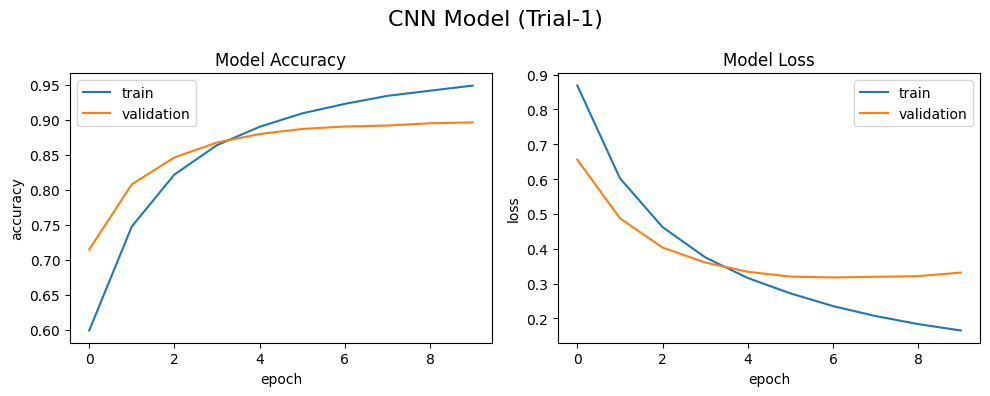

In [ ]:
plotting_model_measurements(cnn_model_trial1_history,'CNN',1)


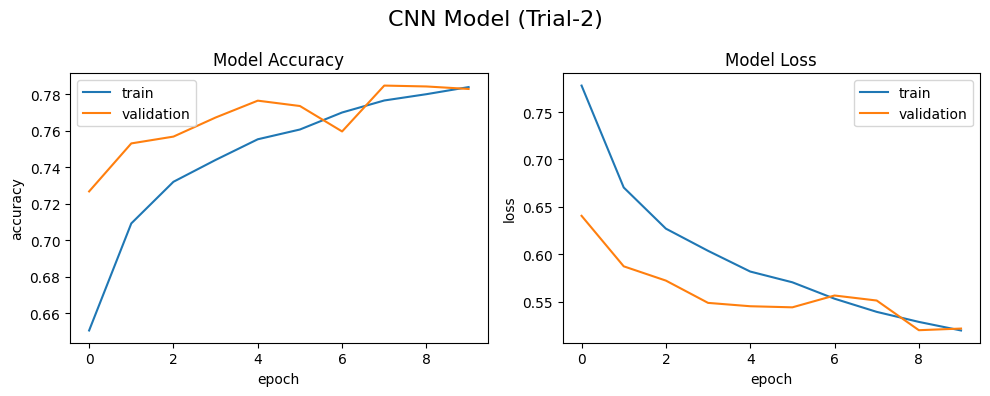

In [ ]:
plotting_model_measurements(cnn_model_trial2_history,'CNN',2)


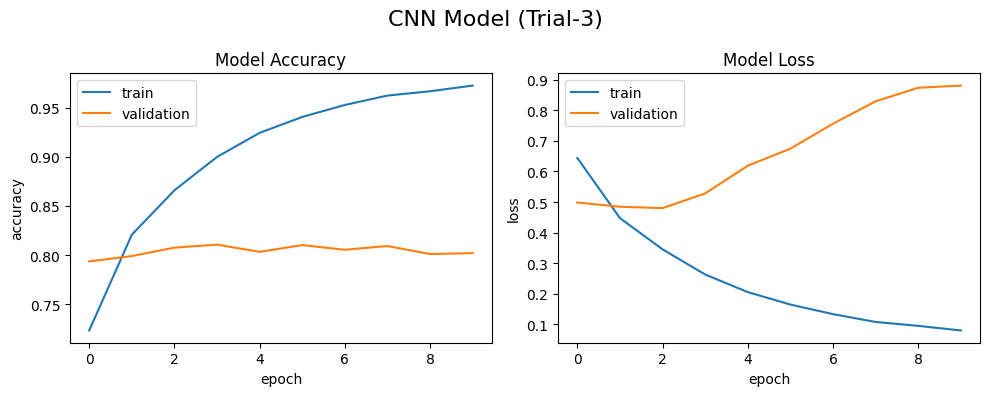

In [ ]:
plotting_model_measurements(cnn_model_trial3_history,'CNN',3)


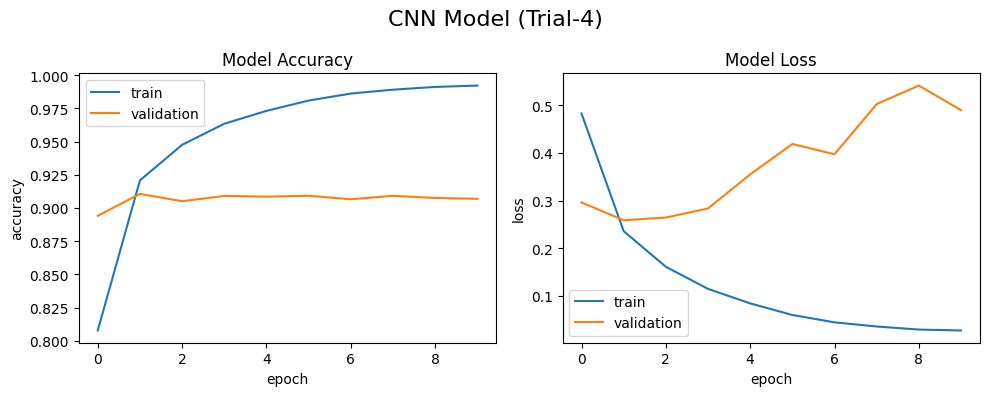

In [ ]:
plotting_model_measurements(cnn_model_trial4_history,'CNN',4)


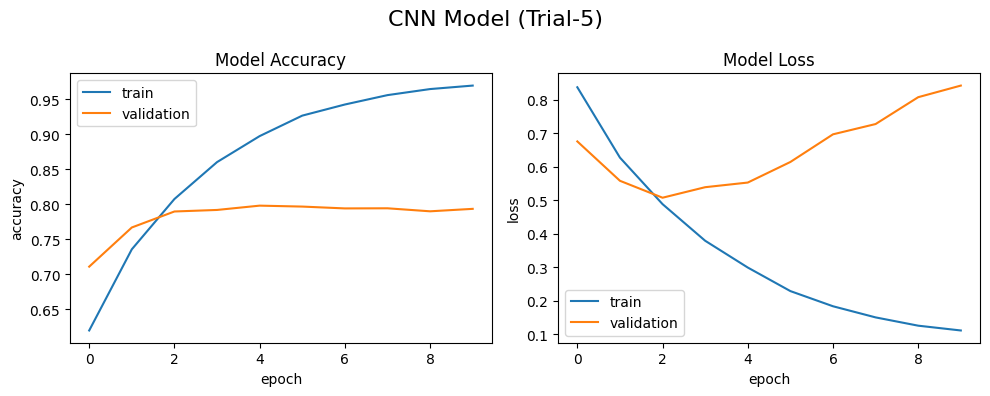

In [ ]:
plotting_model_measurements(cnn_model_trial5_history,'CNN',5)


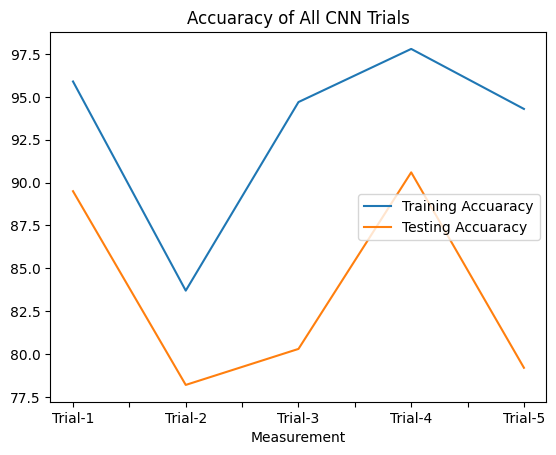

In [ ]:
cnn_model_trials_df[['Measurement','Training Accuaracy','Testing Accuaracy']].plot(x='Measurement', title = 'Accuaracy of All CNN Trials');
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CNN Model (All Trials Accuracies).png')



In [ ]:
cnn_model_trial1.save('/content/drive/MyDrive/Colab Notebooks/CNN/CNN_model_trial1_Saved')
cnn_model_trial2.save('/content/drive/MyDrive/Colab Notebooks/CNN/CNN_model_trial2_Saved')
cnn_model_trial3.save('/content/drive/MyDrive/Colab Notebooks/CNN/CNN_model_trial3_Saved')
cnn_model_trial4.save('/content/drive/MyDrive/Colab Notebooks/CNN/CNN_model_trial4_Saved')
cnn_model_trial5.save('/content/drive/MyDrive/Colab Notebooks/CNN/CNN_model_trial5_Saved')
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial5_Saved')


In [ ]:
def build_LSTM(Conv1D,Dense1,Dense2,lstm_units,_learning_rate,embedding_trainable,optimizer_type,model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer'))
    if Conv1D:
      model.add(layers.Conv1D(64, 8, activation = 'relu'))

    model.add(layers.Bidirectional(layers.LSTM(lstm_units, dropout = 0.2, recurrent_dropout = 0.2)))

    if Dense1:
      model.add(layers.Dense(256, activation='relu'))
      model.add(layers.Dropout(0.5))

    if Dense2:
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dropout(0.5))

    model.add(layers.Dense(3, activation='softmax',name='Output_Layer'))
    model.layers[0].set_weights([embedding_matrix])
    if embedding_trainable:
       model.layers[0].trainable = True
    else:
       model.layers[0].trainable = False

    if optimizer_type=='adam':
      model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),metrics=['accuracy',f1_m,precision_m, recall_m])
    else:
      model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.RMSprop(learning_rate=_learning_rate),metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    return model


lstm_model_trials_dict = {
             'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}


In [ ]:
# Trial-1 (embedding_trainable=True)

lstm_model_trial1 = build_LSTM(Conv1D=False , Dense1=False , Dense2=True , lstm_units=64 , _learning_rate=0.01 , embedding_trainable=True , optimizer_type='adam' , model_name='LSTM_Trial-1')
lstm_model_trial1_history = lstm_model_trial1.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-1'''
tf.keras.utils.plot_model(lstm_model_trial1, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/LSTM Model (Trial 1).png")

lstm_model_trials_dict['Embedding layer Trainable'][0]='Yes'



# Trial-2 (embedding_trainable=False)

lstm_model_trial2 = build_LSTM(Conv1D=True , Dense1=False , Dense2=False , lstm_units=512 , _learning_rate=0.001 , embedding_trainable=False , optimizer_type='adam' , model_name='LSTM_Trial-2')
lstm_model_trial2_history = lstm_model_trial2.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(lstm_model_trial2, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/LSTM Model (Trial 2).png")

lstm_model_trials_dict['Embedding layer Trainable'][1]='No'

# Trial-3 (embedding_trainable=False)

lstm_model_trial3 = build_LSTM(Conv1D=False , Dense1=True , Dense2=False , lstm_units=128 , _learning_rate=0.001 , embedding_trainable=False , optimizer_type='rmsp' , model_name='LSTM_Trial-3')
lstm_model_trial3_history = lstm_model_trial3.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(lstm_model_trial3, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/LSTM Model (Trial 3).png")

lstm_model_trials_dict['Embedding layer Trainable'][2]='No'




# Trial-4 (embedding_trainable=True)

lstm_model_trial4 = build_LSTM(Conv1D=True , Dense1=True , Dense2=True , lstm_units=128 , _learning_rate=0.001 , embedding_trainable=True , optimizer_type='rmsp' , model_name='LSTM_Trial-4')
lstm_model_trial4_history = lstm_model_trial4.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(lstm_model_trial4, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/LSTM Model (Trial 4).png")

lstm_model_trials_dict['Embedding layer Trainable'][3]='Yes'

# Trial-5 (embedding_trainable=True)

lstm_model_trial5 = build_LSTM(Conv1D=True , Dense1=True , Dense2=False , lstm_units=256 , _learning_rate=0.001 , embedding_trainable=True , optimizer_type='adam' , model_name='LSTM_Trial-5')
lstm_model_trial5_history = lstm_model_trial5.fit(X_train, y_train,epochs=6, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(lstm_model_trial5, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/LSTM Model (Trial 5).png")

lstm_model_trials_dict['Embedding layer Trainable'][4]='Yes'



Model: "LSTM_Trial-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 Output_Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 9795331 (37.37 MB)
Trainable params: 979

Model: "LSTM_Trial-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_11 (Conv1D)          (None, 42, 64)            153664    
                                                                 
 bidirectional_2 (Bidirecti  (None, 1024)              2363392   
 onal)                                                           
                                                                 
 Output_Layer (Dense)        (None, 3)                 3075      
                                                                 
Total params: 12120131 (46.23 MB)
Trainable params: 2520131 (9.61 MB)
Non-trainable params: 9600000 (36.62 MB)
_________________________________________________________________
Epoch 1/6

Model: "LSTM_Trial-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               439296    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 Output_Layer (Dense)        (None, 3)                 771       
                                                                 
Total params: 10105859 (38.55 MB)
Trainable params: 50

Model: "LSTM_Trial-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_12 (Conv1D)          (None, 42, 64)            153664    
                                                                 
 bidirectional_4 (Bidirecti  (None, 256)               197632    
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 64)               

Model: "LSTM_Trial-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 42, 64)            153664    
                                                                 
 bidirectional_5 (Bidirecti  (None, 512)               657408    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 Output_Layer (Dense)        (None, 3)                

In [ ]:
# Trial-1
training_score = lstm_model_trial1.evaluate(X_train, y_train)
testing_score = lstm_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)



# Trial-2
training_score = lstm_model_trial2.evaluate(X_train, y_train)
testing_score = lstm_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)
# Trial-3
training_score = lstm_model_trial3.evaluate(X_train, y_train)
testing_score = lstm_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)




# Trial-4
training_score = lstm_model_trial4.evaluate(X_train, y_train)
testing_score = lstm_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)

# Trial-5
training_score = lstm_model_trial5.evaluate(X_train, y_train)
testing_score = lstm_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)


1371/1371 [==============================] - 43s 31ms/step - loss: 0.3155 - accuracy: 0.9033 - f1_m: 0.9035 - precision_m: 0.9067 - recall_m: 0.9004

Trial 1
Training Accuaracy (Trial 1): 95.4%
Testing Accuaracy (Trial 1): 90.3%
1371/1371 [==============================] - 41s 30ms/step - loss: 0.4260 - accuracy: 0.8423 - f1_m: 0.8413 - precision_m: 0.8530 - recall_m: 0.8302

Trial 2
Training Accuaracy (Trial 2): 91.7%
Testing Accuaracy (Trial 2): 84.2%
1371/1371 [==============================] - 44s 32ms/step - loss: 0.3643 - accuracy: 0.8612 - f1_m: 0.8562 - precision_m: 0.8844 - recall_m: 0.8306

Trial 3
Training Accuaracy (Trial 3): 87.9%
Testing Accuaracy (Trial 3): 86.1%
1371/1371 [==============================] - 40s 29ms/step - loss: 0.3034 - accuracy: 0.9068 - f1_m: 0.9064 - precision_m: 0.9107 - recall_m: 0.9023

Trial 4
Training Accuaracy (Trial 4): 95.0%
Testing Accuaracy (Trial 4): 90.7%
1371/1371 [==============================] - 38s 28ms/step - loss: 0.3334 - accuracy

In [ ]:
lstm_model_trials_df = pd.DataFrame(lstm_model_trials_dict)
lstm_model_trials_df.to_csv('/content/drive/MyDrive/Colab Notebooks/LSTM_Trials_Table.csv')
lstm_model_trials_df

,Measurement,Training Accuaracy,Testing Accuaracy,Loss,Embedding layer Trainable
0,Trial-1,95.4,90.3,0,Yes
1,Trial-2,91.7,84.2,0,No
2,Trial-3,87.9,86.1,0,No
3,Trial-4,95.0,90.7,0,Yes
4,Trial-5,97.0,91.2,0,Yes


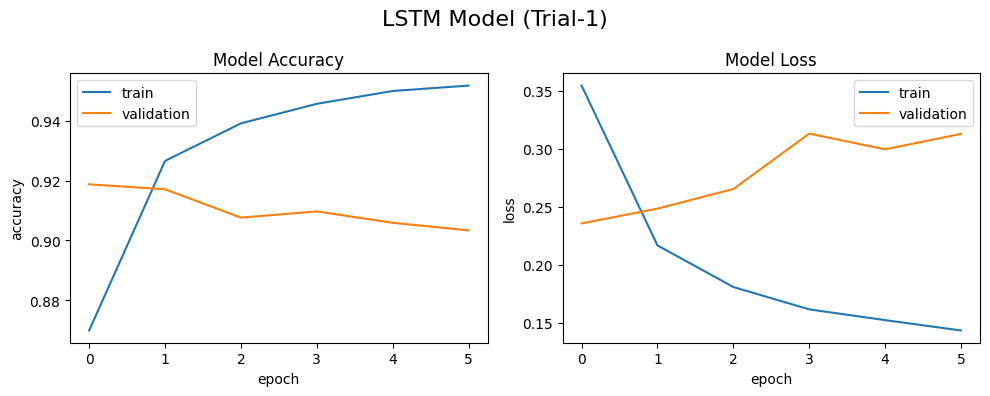

In [ ]:
plotting_model_measurements(lstm_model_trial1_history,'LSTM',1)

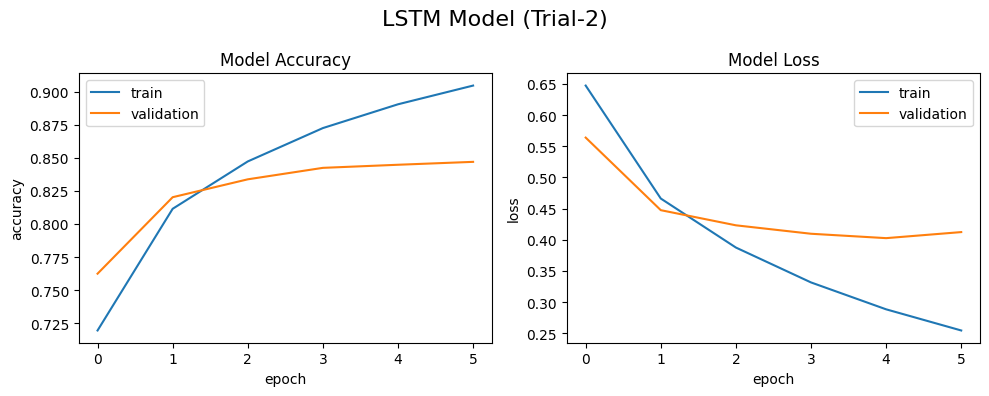

In [ ]:
plotting_model_measurements(lstm_model_trial2_history,'LSTM',2)

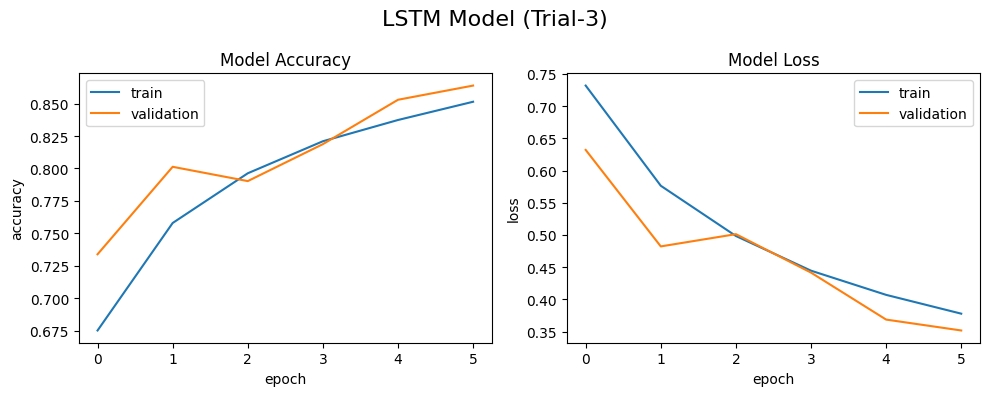

In [ ]:
plotting_model_measurements(lstm_model_trial3_history,'LSTM',3)

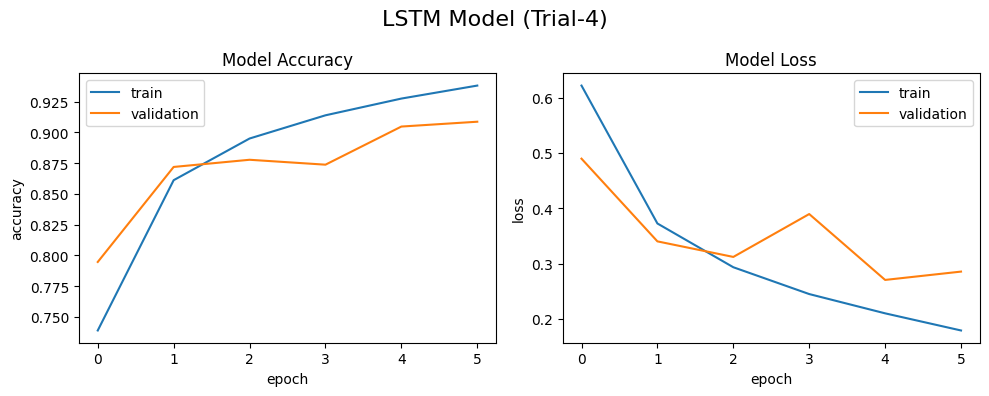

In [ ]:
plotting_model_measurements(lstm_model_trial4_history,'LSTM',4)

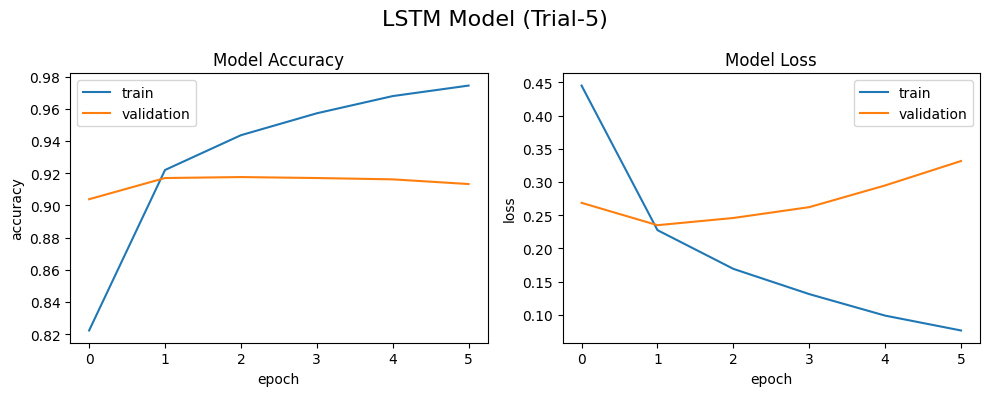

In [ ]:
plotting_model_measurements(lstm_model_trial5_history,'LSTM',5)

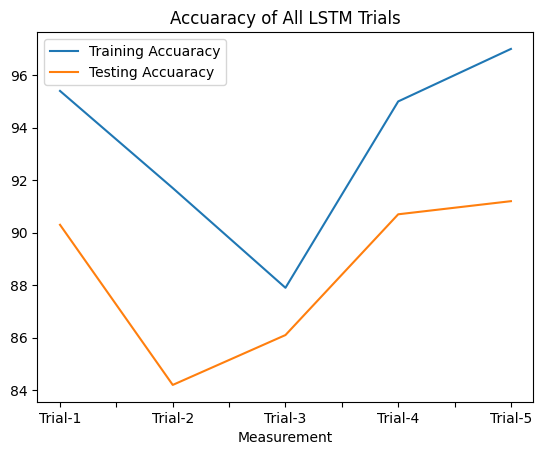

In [ ]:
lstm_model_trials_df[['Measurement','Training Accuaracy','Testing Accuaracy']].plot(x='Measurement', title = 'Accuaracy of All LSTM Trials');
plt.savefig('/content/drive/MyDrive/Colab Notebooks/LSTM Model (All Trials Accuracies).png')


In [ ]:
lstm_model_trial1.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model_trial1_Saved')
lstm_model_trial2.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model_trial2_Saved')
lstm_model_trial3.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model_trial3_Saved')
lstm_model_trial4.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model_trial4_Saved')
lstm_model_trial5.save('/content/drive/MyDrive/Colab Notebooks/LSTM_model_trial5_Saved')
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial5_Saved')


In [ ]:
def sentiment_category(label_id):
    label = ''
    if label_id==1:
        label = 'positive'
    elif label_id==2:
        label = 'neutral'
    else:
        label = 'negative'
    return label


In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CNN/CNN_model_trial4_Saved',
                                              custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m })
cnn_model.summary()

Model: "CNN_Trial-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, 49, 128)           614528    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 16, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 16, 128)           262272    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                       

In [ ]:
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)

In [ ]:
print(new_tweet)

['high', 'quality', 'pants', 'comfortable', 'great', 'sport', 'activities', 'good', 'price', 'nice', 'quality', 'recommend', 'fans', 'sports']


In [ ]:
new_tweet=lemmatizer.lemmatize(tweet)
print(new_tweet)

High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports


In [ ]:
# Postive Example
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = "Sooo SAD I will miss you here in San Diego"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')

# Negative Example
tweet = " My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')


1/1 [==============================] - 0s 34ms/step
Text: [[1.0688247e-21 1.0000000e+00 1.2012354e-13]]
Label ID: 1
Label Name: positive
Polarity: 1.0


1/1 [==============================] - 0s 27ms/step
Text: [[1.0000000e+00 1.3313034e-17 1.3174679e-10]]
Label ID: 0
Label Name: negative
Polarity: 1.0


1/1 [==============================] - 0s 27ms/step
Text: [[2.9822970e-14 1.0000000e+00 4.9679034e-09]]
Label ID: 1
Label Name: positive
Polarity: 1.0




In [ ]:
lstm_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LSTM_model_trial5_Saved',
                                              custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m })
lstm_model.summary()

Model: "LSTM_Trial-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding  (None, 49, 300)           9600000   
 )                                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 42, 64)            153664    
                                                                 
 bidirectional_5 (Bidirecti  (None, 512)               657408    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 Output_Layer (Dense)        (None, 3)                

In [ ]:
# Postive Example
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = "Sooo SAD I will miss you here in San Diego"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')

# neutral Example
tweet = " My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!"  # neutral

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



1/1 [==============================] - 1s 1s/step
Text: [[1.0891816e-03 9.9841809e-01 4.9271871e-04]]
Label ID: 1
Label Name: positive
Polarity: 0.9984180927276611


1/1 [==============================] - 0s 41ms/step
Text: [[9.998665e-01 3.795586e-05 9.561568e-05]]
Label ID: 0
Label Name: negative
Polarity: 0.9998664855957031


1/1 [==============================] - 0s 49ms/step
Text: [[1.7793303e-04 9.9961722e-01 2.0478816e-04]]
Label ID: 1
Label Name: positive
Polarity: 0.9996172189712524




In [ ]:
import pickle

In [ ]:
pickle.dump(lstm_model,open('lstm_model.sav','wb'))

In [ ]:
mod=pickle.load(open('lstm_model.sav','rb'))

In [ ]:
new_tweet=clean_text('Sooo SAD I will miss you here in San Diego')
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

In [ ]:
print(mod.predict(data))
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')


1/1 [==============================] - 0s 45ms/step
[[1.7793303e-04 9.9961722e-01 2.0478816e-04]]
Text: [[1.7793303e-04 9.9961722e-01 2.0478816e-04]]
Label ID: 1
Label Name: positive
Polarity: 0.9996172189712524




In [ ]:
pickle.dump(cnn_model,open('cnn_model.sav','wb'))

In [ ]:
modc=pickle.load(open('cnn_model.sav','rb'))

In [ ]:
print(modc.predict(data))
label_id = np.argmax(output)
print(f'Text: {output}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')


1/1 [==============================] - 1s 509ms/step
[[2.9822970e-14 1.0000000e+00 4.9679034e-09]]
Text: [[1.7793303e-04 9.9961722e-01 2.0478816e-04]]
Label ID: 1
Label Name: positive
Polarity: 0.9996172189712524


